In [26]:
using Plots

In [27]:
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy, batch
using StatsBase: wsample
using Base.Iterators: partition
using CSV
using MultivariateStats
using LinearAlgebra
using StatsBase
using Random
using BSON: @save, @load
using BSON
using Dates
using Plots
using Statistics
using DataFrames
using JLD

# CNN Demo

In [49]:
d = JLD.load("ConvVars.jld")

Dict{String,Any} with 2 entries:
  "test_data"   => Any[[0.127749 -1.15192 … 0.741817 0.353458; 0.348764 -0.9553…
  "true_forces" => Any[1.40906, 1.37907, 2.82411, 1.4304, 1.51713, 7.29244, 1.5…

In [50]:
using BSON
BSON.@load "CNN-model_latest.bson" m opt

In [51]:
test_data = d["test_data"];
true_forces = d["true_forces"]

max_forces = maximum(true_forces);
min_forces = minimum(true_forces);
# change 1 to a few examples

In [52]:
return_data(x,i) = x[i][:,1];

In [53]:
get_guess(x,model) = model(x).data[1];

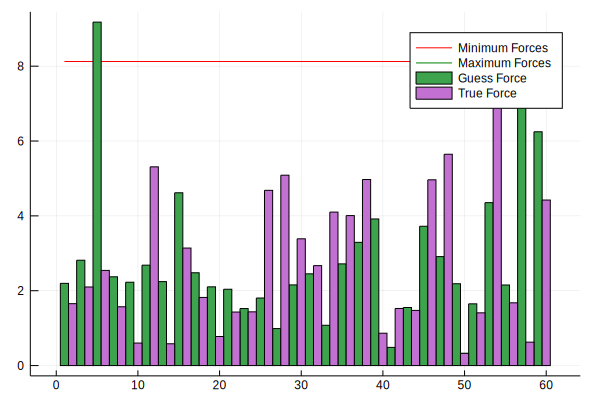

In [48]:
sample_vec = shuffle(1:length(test_data));
using Plots
gr(show = :ijulia)

guesses = [];
true_vec = [];
idx = 1;
sample_vec = sample_vec[1:30];
for i in 1:2:(length(sample_vec)*2)
# for (i,sample_idx) in enumerate(sample_vec)
    sample_idx = sample_vec[idx];
    input_data = reshape(test_data[sample_idx], (size(test_data[sample_idx],1), size(test_data[sample_idx],2), 1, 1));
#     guesses = m(input_data).data[1];
    append!(guesses, m(input_data).data[1]);
    append!(true_vec, true_forces[sample_idx]);
    if idx >= 2
        plot(fill(max_forces, length(sample_vec)*2), color="red", label = "Minimum Forces")
        plot!(fill(min_forces, length(sample_vec)*2), color="green", label = "Maximum Forces")
        bar!(1:2:i,guesses, label = "Guess Force", bar_width = 1)
        bar!(2:2:i+1,true_vec, label = "True Force", bar_width = 1)
        sleep(.2)
        IJulia.clear_output(true)
    end
    idx = idx + 1;
end

# Best PC Demo

In [38]:
BSON.@load "BestPC-model1212.bson" m opt
using JLD
d3 = load("BestPC_lr01Vars_1212.jld");
d4 = load("BestPC_lr01Vars_1213_noOneHot.jld");

In [39]:
test_dataOH = d3["test_data"];
test_labelsOH = d3["labels"];
alphabet = d3["alphabet"];

In [40]:
test_data = d4["test_data_noOH"];
test_labels = d4["labels_noOH"];

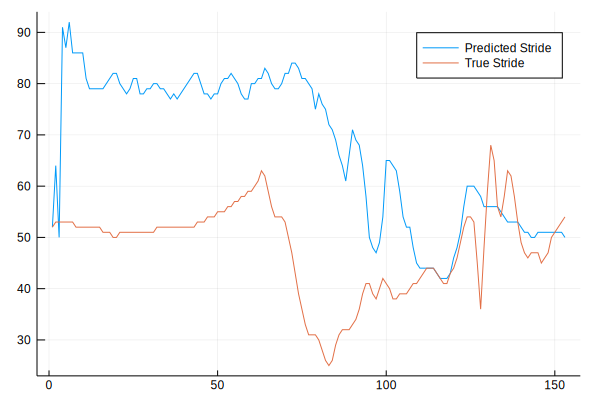

InterruptException: InterruptException:

In [42]:
function sample_fun(m, alphabet, primer, len; temp = 1)
  Flux.reset!(m)
  buf = []
  c = primer
  for i = 1:len
    append!(buf,c)
    c = wsample(alphabet, m(onehot(c, alphabet)).data)
  end
  return buf
end
tst_data_stride = test_data;

avail_samples = collect(1:length(tst_data_stride)-1);
buffer = [];
s_order = [];
while length(avail_samples)>1
    sample_idx = sample(1:length(tst_data_stride));
    predictions = sample_fun(m, alphabet, tst_data_stride[sample_idx][1], length(tst_data_stride[sample_idx]));
    append!(buffer, [predictions]);
    using Plots
    gr(show = :ijulia)
    for i in 2:length(predictions)
        plot(1:i, predictions[1:i], label = "Predicted Stride")
        plot!(1:i, test_labels[sample_idx][1:i], label = "True Stride")
        sleep(0.1)
        IJulia.clear_output(true)
    end
    setdiff!(avail_samples, sample_idx)
    append!(s_order, sample_idx)
end